# Deep Convolutional Generative Adversarial Network

## Step 1: Setup

### Import Packages 

In [0]:
# !pip uninstall tensorflow
# !pip install tensorflow-gpu
# !pip install --upgrade grpcio

In [2]:
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


In [3]:
import os
import glob
import datetime

import imageio
from PIL import Image
from IPython import display
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

print("%d GPUs are available for tensorflow %s in current environment." % 
      (len(tf.config.experimental.list_physical_devices('GPU')), tf.__version__))
# %load_ext tensorboard

1 GPUs are available for tensorflow 2.0.0 in current environment.


### Set the Paths of the Outputs

In [0]:
# get the dictionary for the project
pwd = '/drive/My Drive/Colab Notebooks/2019Fall-AML-FP-GAN'
# set and create the path for log file for tesnorboard
log_dir = os.path.join(pwd, 'outputs', 'logs')
os.makedirs(log_dir, exist_ok = True)
# set and create the path for saving the images
image_dir = os.path.join(pwd, 'outputs', 'images')
os.makedirs(image_dir, exist_ok = True)
# set and create the path for saving the weights of the model
checkpoint_dir = os.path.join(pwd, 'outputs', 'checkpoints')
os.makedirs(checkpoint_dir, exist_ok = True)

In [5]:
# config the version of training, structure of model and usage of dataset
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
structure = 'GAN'
dataset = 'MNIST'
config = "%s-%s-%s" % (structure, dataset, stamp)
config

'GAN-MNIST-20191127-013034'

### Load and Prepare the Dataset

In [0]:
# load mnist data
(mnist_train, _), (mnist_val, _) = tf.keras.datasets.mnist.load_data()
# load svhn data
svhn_train = tfds.load("svhn_cropped", with_info=False, as_supervised=True, split=tfds.Split.TRAIN)
svhn_val = tfds.load("svhn_cropped", with_info=False, as_supervised=True, split=tfds.Split.TEST)

In [0]:
# normalize data
def mnist_preprocess(x):        
    x = 2*tf.cast(x, dtype=tf.float32)/255 - 1
    # expand the 3d tensor to 4d
    x = tf.expand_dims(x, axis=-1)
    return x

def svhn_preprocess(x, y):        
    x = 2*tf.cast(x, dtype=tf.float32)/255 - 1      
    return x

In [9]:
# preprocess the MNIST dataset
mnist_train_db = tf.data.Dataset.from_tensor_slices(mnist_train).map(mnist_preprocess).shuffle(60000)
mnist_val_db = tf.data.Dataset.from_tensor_slices(mnist_val).map(mnist_preprocess)
# get one batch and check the dimension of this batch
mnist_samples = next(iter(mnist_val_db.batch(32)))
print("shape of one batch for MNIST images is: " + str(mnist_samples.shape))
# preprocess the SVHN dataset
svhn_train_db = svhn_train.map(svhn_preprocess).shuffle(60000)
svhn_val_db = svhn_val.map(svhn_preprocess)
svhn_samples = next(iter(svhn_val_db.batch(32)))
print("shape of one batch for SVHN images is: " + str(svhn_samples.shape))

shape of one batch for MNIST images is: (32, 28, 28, 1)
shape of one batch for SVHN images is: (32, 32, 32, 3)


## Step 2: Define the Generator and Discriminator

### The Generator

In [0]:
class Generator(tf.keras.Model):
    
    def __init__(self, size, channel):
        super().__init__()
        
        self.fc0 = layers.Dense(size*size*256, use_bias=False)
        self.bn0 = layers.BatchNormalization()
        
        self.conv1 = layers.Conv2DTranspose(filters=128, kernel_size=5, strides=1, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        
        self.conv2 = layers.Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding='same', use_bias=False)
        self.bn2 = layers.BatchNormalization()
        
        self.conv3 = layers.Conv2DTranspose(filters=channel, kernel_size=5, strides=2, padding='same', use_bias=False)

        self.size = size
         
    def call(self, inputs, training=None):
        x = self.fc0(inputs)   
        x = tf.reshape(x, [-1, self.size, self.size, 256]) 
        x = tf.nn.leaky_relu(x)
        
        x = tf.nn.leaky_relu(self.bn1(self.conv1(x), training=training))
        
        x = tf.nn.leaky_relu(self.bn2(self.conv2(x), training=training))
        
        image = tf.math.tanh(self.conv3(x))
        
        return image

In [11]:
if dataset == 'MNIST':
    generator = Generator(size = 7, channel = 1)
elif dataset == 'SVHN':
    generator = Generator(size = 8, channel = 3)
seed = tf.random.normal([32, 100])
image_fake = generator(seed, training=False)
print("The shape of the output of the generator is: " + str(image_fake.shape))

The shape of the output of the generator is: (32, 28, 28, 1)


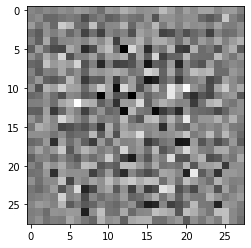

In [12]:
if dataset == 'MNIST':
    plt.imshow(image_fake[0, :, :, 0], cmap='gray')
    plt.show()
else:
    plt.imshow(image_fake[0, :, :, :])
    plt.show()

### The Discriminator

In [0]:
class Discriminator(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        self.conv1 = layers.Conv2D(filters=64, kernel_size=5, strides=2, padding='same')
        self.dropout1 = layers.Dropout(0.3)
        
        self.conv2 = layers.Conv2D(filters=128, kernel_size=5, strides=2, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.dropout2 = layers.Dropout(0.3)
        
        self.conv3 = layers.Conv2D(filters=256, kernel_size=5, strides=2, padding='same')
        self.bn3 = layers.BatchNormalization()
        self.dropout3 = layers.Dropout(0.3)
        
        self.flatten = layers.Flatten()
        self.fc = layers.Dense(1)
        
    def call(self, inputs, training=None):
        x = tf.nn.leaky_relu(self.dropout1(self.conv1(inputs)))
        x = self.dropout2(tf.nn.leaky_relu(self.bn2(self.conv2(x), training=training)))
        x = self.dropout3(tf.nn.leaky_relu(self.bn3(self.conv3(x), training=training)))
        
        x = self.flatten(x)
        logits = self.fc(x)
        
        return logits

In [14]:
discriminator = Discriminator()
logits = discriminator(image_fake, training=False)
print("The shape of logits given by discriminator is: " + str(logits.shape))

The shape of logits given by discriminator is: (32, 1)


## Step 3: Define some Helper Functions

In [0]:
loss_cal = tf.losses.BinaryCrossentropy(from_logits=True)

### Gradient Penalty Calculator for WGAN

In [0]:
def gradient_penalty_cal(discriminator, image_fake, image_true):
    
    # [b, 1, 1, 1] -> [b, h, w, c]
    batch = image_true.shape[0]
    alpha = tf.random.uniform([batch, 1, 1, 1])
    alpha = tf.broadcast_to(alpha, image_true.shape)
    
    interplate = alpha * image_true + (1-alpha)*image_fake
    
    with tf.GradientTape() as tape:
        tape.watch(interplate)
        interplate_logits = discriminator(interplate)
    grads = tape.gradient(interplate_logits, interplate)
    
    # [b, h, w, c] -> [b, h*w*c] -> [b]
    grads = tf.reshape(grads, [batch, -1])
    norm = tf.norm(grads, axis=1)
    
    grads_penalty = tf.reduce_mean(tf.math.squared_difference(norm, 1))
    
    return grads_penalty

### Discriminator Loss Calculator

In [0]:
def discriminator_loss_cal(generator, discriminator, seed, image_true, training, LAMBDA=1.):
    
    image_fake = generator(seed, training)
    
    # treat real image as real
    logits_real = discriminator(image_true, training)
    loss_real = tf.reduce_mean(loss_cal(tf.ones_like(logits_real), logits_real))
    # treat fake image as fake
    logits_fake = discriminator(image_fake, training)
    loss_fake = tf.reduce_mean(loss_cal(tf.zeros_like(logits_fake), logits_fake)) 
    
    loss = loss_fake + loss_real
    if structure == 'GAN':
        return loss
    elif structure == 'WGAN':
        gradient_penalty = gradient_penalty_cal(discriminator, image_true, image_fake)
        loss += LAMBDA * gradient_penalty
    
    return (loss, gradient_penalty)

### Generator Loss Calculator

In [0]:
def generator_loss_cal(generator, discriminator, seed, training):
    
    image_fake = generator(seed, training)
    logits_fake = discriminator(image_fake, training)
    
    loss = tf.reduce_mean(loss_cal(tf.ones_like(logits_fake), logits_fake))     
    return loss

### Image Saver

In [0]:
def save_image(images, height, width, image_path, index):

    images = ((images + 1.0) * 127.5).astype(np.uint8)
    # final picture which save as PNG
    picture = np.array([])
    
    row = np.array([])
    for i in range(height*width):
        # concat image into a row
        if row.size == 0:
            row = images[i]
        else:
            row = np.concatenate((row, images[i]), axis=1)

        # concat image row to picture
        if (i+1) % width == 0:
            if picture.size == 0:
                picture = row
            else:
                picture = np.concatenate((picture, row), axis=0)
            # reset single row
            row = np.array([])
    
    picture_board = tf.expand_dims(tf.cast(picture, dtype=tf.uint8), 0)
    with summary_writer.as_default(): 
        tf.summary.image('train-fake-images:', picture_board, step=index)
    
    if 'MNIST' in image_path:
        picture = np.squeeze(picture, axis=2)
        Image.fromarray(picture, 'P').save(image_path)
    elif 'SVHN' in image_path:
        Image.fromarray(picture, 'RGB').save(image_path)

## Step 4: Define the Training Loop

In [0]:
# number of epochs
EPOCH = 100
BATCH = 256
# step size, i.e. number of batches per validation
STEP = 100
SAVE = 50

SEED = 100
LAMBDA = 10.
LEARNING_RATE_D = 1e-4
LEARNING_RATE_G = 1e-3

RESTORE = None

In [0]:
if dataset == 'MNIST':
    train_db = mnist_train_db.batch(BATCH, drop_remainder=True)
    val_db = mnist_val_db.batch(BATCH, drop_remainder=True)
elif dataset == 'SVHN':
    train_db = svhn_train_db.batch(BATCH, drop_remainder=True)
    val_db = svhn_val_db.batch(BATCH, drop_remainder=True)

In [0]:
generator_optimizer = tf.optimizers.Adam(learning_rate=LEARNING_RATE_G)
discriminator_optimizer = tf.optimizers.Adam(learning_rate=LEARNING_RATE_D)

In [0]:
# save the training process
checkpoint_prefix = os.path.join(checkpoint_dir, config, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# the log file created for tensorborad for this time of training
cur_log_dir = os.path.join(log_dir, config)
summary_writer = tf.summary.create_file_writer(cur_log_dir) 

# the file for saving images for this time of training
cur_image_dir = os.path.join(image_dir, config)
os.makedirs(cur_image_dir, exist_ok = True)

# if you want to see the visualization during the traing, run this line
# %tensorboard --logdir=log_dir

In [25]:
# restore the pretrained model
if RESTORE:
    restore_checkpoint_dir = os.path.join(checkpoint_dir, restore)
    checkpoint.restore(tf.train.latest_checkpoint(restore_checkpoint_dir))
    
# number of batches have trained
index = -1
for epoch in range(1, EPOCH+1):
    
    for step, image_true in enumerate(train_db):
        
        seed = tf.random.uniform([BATCH, SEED], minval=-1, maxval=1)
        # train Discriminator
        with tf.GradientTape() as tape:
            if structure == 'GAN':
                discriminator_loss = discriminator_loss_cal(generator, discriminator, seed, image_true, training=True)
            elif structure == 'WGAN':
                discriminator_loss, gradient_penalty = discriminator_loss_cal(generator, discriminator, seed, image_true, training=True)
        grads = tape.gradient(discriminator_loss, discriminator.trainable_weights)
        discriminator_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))
        
        # train Generator
        with tf.GradientTape() as tape:
            generator_loss = generator_loss_cal(generator, discriminator, seed, training=True)
        grads = tape.gradient(generator_loss, generator.trainable_weights)
        generator_optimizer.apply_gradients(zip(grads, generator.trainable_weights))     
        
        if step % STEP == 0:
            index += 1
            print("At epoch: %s/%d, after %s batches have been trained: discriminator loss: %.5f, generator loss: %.5f" % 
                  (format(epoch, '2'), EPOCH, format(step,'2'), float(discriminator_loss), float(generator_loss)))
            
            with summary_writer.as_default(): 
                tf.summary.scalar('train-generator-loss', float(generator_loss), step=index) 
                tf.summary.scalar('train-discriminator-loss', float(discriminator_loss), step=index) 
                
            fake_image = generator(seed, training=False)
            image_path = os.path.join(cur_image_dir, 'after-%d-batches.png' % index)
            save_image(fake_image.numpy(), 5, 5, image_path, index)
    
    if epoch % SAVE == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

At epoch:  1/100, after  0 batches have been trained: discriminator loss: 2.00888, generator loss: 0.89080
At epoch:  1/100, after 100 batches have been trained: discriminator loss: 0.99043, generator loss: 2.89097
At epoch:  1/100, after 200 batches have been trained: discriminator loss: 1.95675, generator loss: 2.43001
At epoch:  2/100, after  0 batches have been trained: discriminator loss: 0.62624, generator loss: 2.40418
At epoch:  2/100, after 100 batches have been trained: discriminator loss: 0.78334, generator loss: 2.46894
At epoch:  2/100, after 200 batches have been trained: discriminator loss: 1.06406, generator loss: 1.72251
At epoch:  3/100, after  0 batches have been trained: discriminator loss: 1.57437, generator loss: 1.47595
At epoch:  3/100, after 100 batches have been trained: discriminator loss: 0.82374, generator loss: 2.20773
At epoch:  3/100, after 200 batches have been trained: discriminator loss: 1.33975, generator loss: 1.81894
At epoch:  4/100, after  0 batc

## Step 5: Visualization

### Greate GIFs

In [0]:
# set the path of the GIF file
anime_path = os.path.join(cur_image_dir, "%s-%s.%s" % (structure, dataset, 'gif'))
# create the GIF with imageio
with imageio.get_writer(anime_path, mode='I') as writer:
    filenames = glob.glob(os.path.join(cur_image_dir, '*.png'))
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
# show the GIF in the notebook
# display.Image(filename=anime_path)

### Tensor Board

In [0]:
# %tensorboard --logdir=log_dir